In [ ]:
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import pickle
from sklearn.manifold import TSNE
import pandas as pd
import re
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) 
nltk.download('wordnet')
from google.colab import drive
drive.mount('/content/drive')

# Read data from file 

In [ ]:
# df1=pd.read_csv('drive/MyDrive/CDAC/Rishabh/Attempt1/at23/data2.csv')
# df2=pd.read_csv('drive/MyDrive/CDAC/Rishabh/Attempt1/at23/data3.csv')
# data=pd.concat([df,df1,df2],ignore_index=True)
# data=data['Body']
# # data=data.dropna(inplace=True)
# data.shape

In [ ]:
# data2=data
# body_length=[]
# for body in data2['Body']:
#   body_length.append(len(body))

# data2['body_length']=body_length
# data.head()

In [ ]:
df=pd.read_csv('drive/MyDrive/CDAC/Rishabh/Attempt1/at23/data1.csv')
data=df[1:100]
data=data['Body']                                                               #shape=[99]
data.columns=['Body']
data=pd.DataFrame(data)
data

##Cleaning Data

In [ ]:
from nltk.stem import WordNetLemmatizer

data2=data
corpus=[]
lemmatizer=WordNetLemmatizer()

for body in data2['Body']:
  removed_newline_tab=re.sub('[\n|\t]',' ',body)
  removed_sub=re.sub('Subject: ',' ',removed_newline_tab)
  removed_spchar=re.sub('[^a-zA-z]',' ',removed_sub)

  lower_cased=removed_spchar.lower()
  tokenized_email=lower_cased.split()

  filtered_words=[word for word in tokenized_email if word not in stopwords.words('english')]
  lemmatized_email=[lemmatizer.lemmatize(word) for word in filtered_words]

  body=' '.join(lemmatized_email)
  corpus.append(body)
  corpus

In [ ]:
with open('drive/MyDrive/CDAC/Rishabh/Attempt1/at23/corpus.pickle','rb') as f:
  text_og=pickle.load(f)
text_og=corpus
len(text_og)

In [ ]:
# def get_file_data(stop_word_removal='no'):
#     file_contents = []
#     with open('jef_archer.txt') as f:
#         file_contents = f.read()
#     text = []
#     for val in file_contents.split('.'):
#         sent = re.findall("[A-Za-z]+", val)
#         line = ''
#         for words in sent:
            
#             if stop_word_removal == 'yes': 
#                 if len(words) > 1 and words not in stop_words:
#                     line = line + ' ' + words
#             else:
#                 if len(words) > 1 :
#                     line = line + ' ' + words
#         text.append(line)
#     return text

# Generate variables 

    word_to_index : A dictionary mapping each word to an integer value {'modern': 0, 'humans': 1}

    index_to_word : A dictionary mapping each word to an integer value {0: 'modern', 1: 'humans'}

    corpus  : The entire data consisting of all the words

    vocab_size : Number of unique words in the corpus

In [ ]:
def generate_dictinoary_data(text):
    word_to_index= dict()
    index_to_word = dict()
    corpus = []
    count = 0
    vocab_size = 0
    
    for row in text:
        for word in row.split():
            word = word.lower()
            corpus.append(word)
            if word_to_index.get(word) == None:
                word_to_index.update ( {word : count})
                index_to_word.update ( {count : word })
                count  += 1
    vocab_size = len(word_to_index)
    length_of_corpus = len(corpus)
    
    return word_to_index,index_to_word,corpus,vocab_size,length_of_corpus

In [ ]:
top_n_words = 5


In [ ]:
# text = get_file_data('yes')
word_to_index,index_to_word,corpus,vocab_size,length_of_corpus = generate_dictinoary_data(text_og)
print('Number of unique words:' , vocab_size)
print('Length of corpus :',length_of_corpus)
words_subset = []
words_subset = np.random.choice(list(word_to_index.keys()),top_n_words)
print(words_subset)

Number of unique words: 5107
Length of corpus : 13604
['reference' 'k' 'moved' 'familiar' 'pixel']


Example: 

In [ ]:
text = ['Best way to success is through hardwork and persistence']
word_to_index,index_to_word,corpus,vocab_size,length_of_corpus = generate_dictinoary_data(text)
print('Number of unique words:' , vocab_size)
print('word_to_index : ',word_to_index)
print('index_to_word : ',index_to_word)
print('corpus:',corpus)
print('Length of corpus :',length_of_corpus)

Number of unique words: 9
word_to_index :  {'best': 0, 'way': 1, 'to': 2, 'success': 3, 'is': 4, 'through': 5, 'hardwork': 6, 'and': 7, 'persistence': 8}
index_to_word :  {0: 'best', 1: 'way', 2: 'to', 3: 'success', 4: 'is', 5: 'through', 6: 'hardwork', 7: 'and', 8: 'persistence'}
corpus: ['best', 'way', 'to', 'success', 'is', 'through', 'hardwork', 'and', 'persistence']
Length of corpus : 9


# Generate training data 

The training data is in the following format :

Example:

    Window size = 2, Vocab size = 9


    We will set the indicies as 1 according to the word_to_index dict i.e natural : 0,  so we set the 0th index as 1 to denote natural

    Target word = best    
    Context words = (way,to)
    Target_word_one_hot_vector = [1, 0, 0, 0, 0, 0, 0, 0, 0]
    Context_word_one_hot_vector = [0, 1, 1, 0, 0, 0, 0, 0, 0]
    
    Target word = way    
    Context words = (best,to,success)
    Target_word_one_hot_vector = [0, 1, 0, 0, 0, 0, 0, 0, 0]
    Context_word_one_hot_vector= [1, 0, 1, 1, 0, 0, 0, 0, 0]
    

In [ ]:
def get_one_hot_vectors(target_word,context_words,vocab_size,word_to_index):
    
    #Create an array of size = vocab_size filled with zeros
    trgt_word_vector = np.zeros(vocab_size)
    
    #Get the index of the target_word according to the dictionary word_to_index. 
    #If target_word = best, the index according to the dictionary word_to_index is 0. 
    #So the one hot vector will be [1, 0, 0, 0, 0, 0, 0, 0, 0]
    index_of_word_dictionary = word_to_index.get(target_word) 
    
    #Set the index to 1
    trgt_word_vector[index_of_word_dictionary] = 1
    
    #Repeat same steps for context_words but in a loop
    ctxt_word_vector = np.zeros(vocab_size)
    
    
    for word in context_words:
        index_of_word_dictionary = word_to_index.get(word) 
        ctxt_word_vector[index_of_word_dictionary] = 1
        
    return trgt_word_vector,ctxt_word_vector

In [ ]:
#Note : Below comments for trgt_word_index, ctxt_word_index are with the above sample text for understanding the code flow

def generate_training_data(corpus,window_size,vocab_size,word_to_index,length_of_corpus,sample=None):

    training_data =  []
    training_sample_words =  []
    for i,word in enumerate(corpus):

        index_target_word = i
        target_word = word
        context_words = []

        #when target word is the first word
        if i == 0:  

            # trgt_word_index:(0), ctxt_word_index:(1,2)
            context_words = [corpus[x] for x in range(i + 1 , window_size + 1)] 


        #when target word is the last word
        elif i == len(corpus)-1:

            # trgt_word_index:(9), ctxt_word_index:(8,7), length_of_corpus = 10
            context_words = [corpus[x] for x in range(length_of_corpus - 2 ,length_of_corpus -2 - window_size  , -1 )]

        #When target word is the middle word
        else:

            #Before the middle target word
            before_target_word_index = index_target_word - 1
            for x in range(before_target_word_index, before_target_word_index - window_size , -1):
                if x >=0:
                    context_words.extend([corpus[x]])

            #After the middle target word
            after_target_word_index = index_target_word + 1
            for x in range(after_target_word_index, after_target_word_index + window_size):
                if x < len(corpus):
                    context_words.extend([corpus[x]])


        trgt_word_vector,ctxt_word_vector = get_one_hot_vectors(target_word,context_words,vocab_size,word_to_index)
        training_data.append([trgt_word_vector,ctxt_word_vector])   
        
        if sample is not None:
            training_sample_words.append([target_word,context_words])   
        
    return training_data,training_sample_words

Example:

In [ ]:
text = ['Best way to success is through hardwork and persistence']
word_to_index,index_to_word,corpus,vocab_size,length_of_corpus = generate_dictinoary_data(text)

In [ ]:
window_size = 2
training_data,training_sample_words = generate_training_data(corpus,2,vocab_size,word_to_index,length_of_corpus,'yes')

In [ ]:
for i in range(len(training_data)):
    print('*' * 50)
    print('Target word:%s . Target vector: %s ' %(training_sample_words[i][0],training_data[i][0]))
    print('Context word:%s . Context  vector: %s ' %(training_sample_words[i][1],training_data[i][1]))

# Forward_back_prop  

In [ ]:
def forward_prop(weight_inp_hidden,weight_hidden_output,target_word_vector):
    
    #target_word_vector = x , weight_inp_hidden =  weights for input layer to hidden layer  
    hidden_layer = np.dot(weight_inp_hidden.T, target_word_vector)
    
    #weight_hidden_output = weights for hidden layer to output layer
    u = np.dot(weight_hidden_output.T, hidden_layer)
    
    y_predicted = softmax(u)
    
    return y_predicted, hidden_layer, u
  
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)


In [ ]:
def backward_prop(weight_inp_hidden,weight_hidden_output,total_error, hidden_layer, target_word_vector,learning_rate):
    
    dl_weight_inp_hidden = np.outer(target_word_vector, np.dot(weight_hidden_output, total_error.T))
    dl_weight_hidden_output = np.outer(hidden_layer, total_error)
    
    # Update weights
    weight_inp_hidden = weight_inp_hidden - (learning_rate * dl_weight_inp_hidden)
    weight_hidden_output = weight_hidden_output - (learning_rate * dl_weight_hidden_output)
    
    return weight_inp_hidden,weight_hidden_output

# Loss and error calculation 

<h4> Error calculation : This is backpropogated to update the weights for the next iteration </h4>

Example: below if we have 2 context words. These are not actual values. 

These are just for showing how the error is calculated

context_words = [1 0 0 1 0]

y_pred = [9 6 5 4 2]

So if we break the context_word vector : [1 0 0 0 0] and [0 0 0 1 0] . 1 at index 0 and 3

    The error should be calculated as :

    diff_1 = y_pred - context_word_vector_1 = [9 6 5 4 2] - [1 0 0 0 0] = [8 6 5 4 2]

    diff_2 = y_pred - context_word_vector_2 = [9 6 5 4 2] - [0 0 0 1 0] = [9 6 5 3 2]
    
    Total_error = diff_1 + diff_2(column_wise) = [17 12 10 7 4]
    
    Since our context vector has only 1 array , we implement the above as:
    
    index_of_1_in_context_words ->
        A dictionary which has the index of 1's in the context_word_vector -> {0: 'yes', 3: 'yes'}
    
    number_of_1_in_context_vector -> A count for the above -> 2
    
    We loop the y_pred array and do the calculations as:
    
    for i,value in enumerate(y_p):
    
         if the ith index of y_pred has a 1 in context_word_vector:
             total_error[i]  -> i:0 . y_pred[i]:9.  -> (9-1) + (1*9) -> error_calculated: 17
             total_error[i]  -> i:3 . y_pred[i]:4.  -> (4-1) + (1*4) -> error_calculated: 7

        else:
         
            total_error[i]  -> i:1 . y_pred[i]:6.  -> 6*2 -> error_calculated: 12
            total_error[i]  -> i:2 . y_pred[i]:5.  -> 5*2 -> error_calculated: 10
            total_error[i]  -> i:4 . y_pred[i]:2.  -> 2*2 -> error_calculated: 4
    
    total_error  ->  [17 12 10 7 4]

In [ ]:
def calculate_error(y_pred,context_words):
    
    total_error = [None] * len(y_pred)
    index_of_1_in_context_words = {}
    
    for index in np.where(context_words == 1)[0]:
        index_of_1_in_context_words.update ( {index : 'yes'} )
        
    number_of_1_in_context_vector = len(index_of_1_in_context_words)
    
    for i,value in enumerate(y_pred):
        
        if index_of_1_in_context_words.get(i) != None:
            total_error[i]= (value-1) + ( (number_of_1_in_context_vector -1) * value)
        else:
            total_error[i]= (number_of_1_in_context_vector * value)
            
            
    return  np.array(total_error)

<h4> Loss calculation: This is the loss after each iteration i.e for target word, how well did we predict the context words </h4>

    u : [ 0.3831286   0.89608496  2.69426738 -1.60230182  0.45482701  0.73644591 1.10365796  1.1675781  -0.78555069]

    context: [0, 1, 1, 0, 0, 0, 0, 0, 0]

    sum_1 = -(0.89608496 + 2.69426738)

    sum_2 = number_of_context_words * np.log(np.sum(np.exp(u)))

    total_loss = sum_1 + sum_2

In [ ]:
def calculate_loss(u,ctx):
    
    sum_1 = 0
    for index in np.where(ctx==1)[0]:
        sum_1 = sum_1 + u[index]
    
    sum_1 = -sum_1
    sum_2 = len(np.where(ctx==1)[0]) * np.log(np.sum(np.exp(u)))
    
    total_loss = sum_1 + sum_2
    return total_loss

# Model training 

In [ ]:
def train(word_embedding_dimension,window_size,epochs,training_data,learning_rate,disp = 'no',interval=-1):
    
    weights_input_hidden = np.random.uniform(-1, 1, (vocab_size, word_embedding_dimension))
    weights_hidden_output = np.random.uniform(-1, 1, (word_embedding_dimension, vocab_size))
    
    
    #For analysis purposes
    epoch_loss = []
    weights_1 = []
    weights_2 = []
    
    for epoch in range(epochs):
        loss = 0

        for target,context in training_data:
            y_pred, hidden_layer, u = forward_prop(weights_input_hidden,weights_hidden_output,target)

            total_error = calculate_error(y_pred, context)

            weights_input_hidden,weights_hidden_output = backward_prop(
                weights_input_hidden,weights_hidden_output ,total_error, hidden_layer, target,learning_rate
            )

            loss_temp = calculate_loss(u,context)
            loss += loss_temp
        
        epoch_loss.append( loss )
        weights_1.append(weights_input_hidden)
        weights_2.append(weights_hidden_output)
        
        if disp == 'yes':
            if epoch ==0 or epoch % interval ==0 or epoch == epochs -1:
                print('Epoch: %s. Loss:%s' %(epoch,loss))
    return epoch_loss,np.array(weights_1),np.array(weights_2)

# Model Inference

<h4> Distance measure between vectors </h4>

In [ ]:
# Input vector, returns nearest word(s)
def cosine_similarity(word,weight,word_to_index,vocab_size,index_to_word):
    
    #Get the index of the word from the dictionary
    index = word_to_index[word]
    
    #Get the correspondin weights for the word
    word_vector_1 = weight[index]
    
    
    word_similarity = {}

    for i in range(vocab_size):
        
        word_vector_2 = weight[i]
        
        theta_sum = np.dot(word_vector_1, word_vector_2)
        theta_den = np.linalg.norm(word_vector_1) * np.linalg.norm(word_vector_2)
        theta = theta_sum / theta_den
        
        word = index_to_word[i]
        word_similarity[word] = theta
    
    return word_similarity #words_sorted

<h4> Print a matrix of similar words </h4>

In [ ]:
def print_similar_words(top_n_words,weight,msg,words_subset):
    
    columns=[]
    
    for i in range(0,len(words_subset)):
        columns.append('similar:' +str(i+1) )
        
    df = pd.DataFrame(columns=columns,index=words_subset)
    df.head()
    
    row = 0
    for word in words_subset:
        
        #Get the similarity matrix for the word: word
        similarity_matrix = cosine_similarity(word,weight,word_to_index,vocab_size,index_to_word)
        col = 0
        
        #Sort the top_n_words
        words_sorted = dict(sorted(similarity_matrix.items(), key=lambda x: x[1], reverse=True)[1:top_n_words+1])
        
        #Create a dataframe to display the similarity matrix
        for similar_word,similarity_value in words_sorted.items():
            df.iloc[row][col] = (similar_word,round(similarity_value,2))
            col += 1
        row += 1
    styles = [dict(selector='caption', 
    props=[('text-align', 'center'),('font-size', '20px'),('color', 'red')])] 
    df = df.style.set_properties(**
                       {'color': 'green','border-color': 'blue','font-size':'14px'}
                      ).set_table_styles(styles).set_caption(msg)
    return df

<h4> Plot words as scatter plot from T-Sne </h4>

In [ ]:
def word_similarity_scatter_plot(index_to_word,weight,plot_title,fig,axes):
    
    labels = []
    tokens = []
    
    for key,value in index_to_word.items():
        tokens.append(weight[key])
        labels.append(value)
        
    #TSNE : Compressing the weights to 2 dimensions to plot the data
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)
    
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    
    
    #plt.figure(figsize=(5, 5)) 
    for i in range(len(x)):
        axes.scatter(x[i],y[i])
        axes.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    #plt.title(plot_title)
    axes.set_title(plot_title, loc='center')

<h4> Epoch - loss plot </h4>

In [ ]:
def plot_epoch_loss(lbl,loss_epoch,plot_title,path):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    i = 0
    fig = plt.figure(figsize=(10, 5), facecolor='w', edgecolor='k',dpi=80)
    plt.suptitle('Epoch vs Loss',fontsize=16)
    
    for key,loss in loss_epoch.items():
        
        
        epoch_count = range(1, len(loss) + 1)

        plt.plot(epoch_count, loss, 'r-',color=colors[i],linewidth=2.0,label = lbl + str(key))

        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        i += 1

    plt.legend(framealpha=1, frameon=True,fontsize='large',edgecolor="inherit",shadow=True)
    plt.title(plot_title)
    plt.savefig(path+plot_title +'.png')
    plt.show()
    plt.close()   
    

# Analysis

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# path_to_save = 'output_images_sample_data/epoc_loss_plot/'
# path_to_save_scatter_plot = 'output_images_sample_data/word_similarity_scatter_plot/'

In [ ]:
path_to_save = 'IMAGES/epoc_loss_plot/'
path_to_save_scatter_plot = 'IMAGES/word_similarity_scatter_plot/'

<h4> Varying dimensions of word embedding </h4>

In [ ]:
window_size = 2
epochs = 100
learning_rate = 0.01
text = ['Best way to success is through hardwork and persistence']

word_to_index,index_to_word,corpus,vocab_size,length_of_corpus = generate_dictinoary_data(text)
training_data,training_sample_words = generate_training_data(corpus,window_size,vocab_size,word_to_index,length_of_corpus)

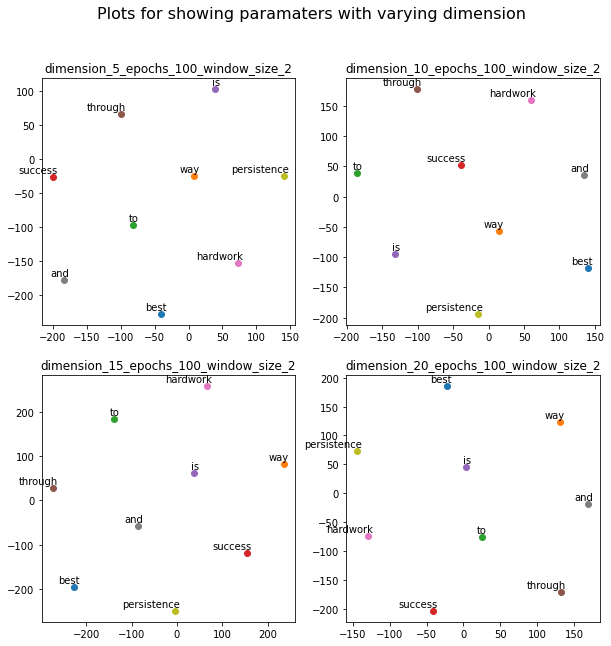

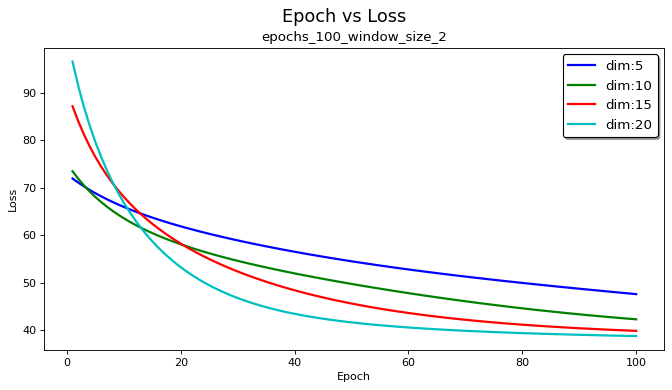

In [ ]:
dimensions = [5,10,15,20]
loss_epoch = {}
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(10,10),)
fig.suptitle("Plots for showing paramaters with varying dimension", fontsize=16)
row=0
col=0
for dim in dimensions:
    
    epoch_loss,weights_1,weights_2 = train(dim,window_size,epochs,training_data,learning_rate)
    loss_epoch.update( {dim: epoch_loss} )
    
    word_similarity_scatter_plot(
        index_to_word,
        weights_1[epochs -1],
        'dimension_' + str(dim) + '_epochs_' + str(epochs) + '_window_size_' +str(window_size),
        fig,
        axes[row][col]
    )
    if col == 1:
        row += 1
        col = 0
    else:
        col += 1

plt.savefig(path_to_save_scatter_plot+'varying_dim' +'.png')
# plt.savefig('varying_dim' +'.png')        
plt.show()

plot_epoch_loss('dim:',loss_epoch,'epochs_' + str(epochs) + '_window_size_' +str(window_size),path_to_save)

<h4> Varying dimensions of window size </h4>

In [ ]:
dimension = 20
epochs = 100
learning_rate = 0.01
text = ['Best way to success is through hardwork and persistence']

word_to_index,index_to_word,corpus,vocab_size,length_of_corpus = generate_dictinoary_data(text)

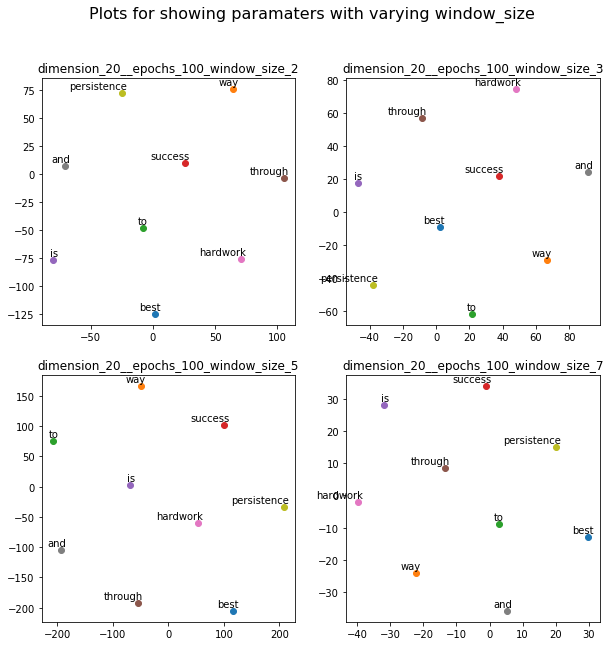

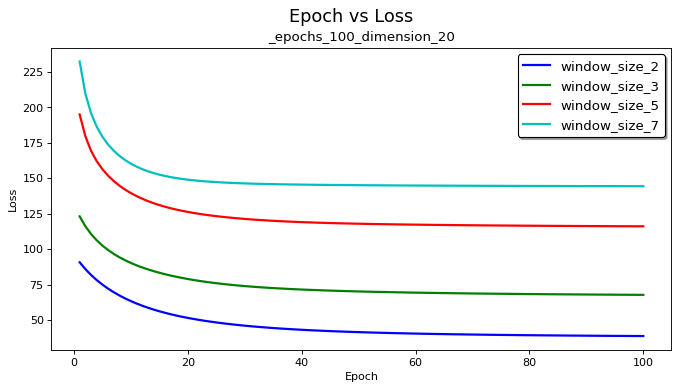

In [ ]:
window_size = [2,3,5,7]
loss_epoch = {}
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(10,10),)
fig.suptitle("Plots for showing paramaters with varying window_size", fontsize=16)
row=0
col=0
for ws in window_size:
    
    training_data,training_sample_words = generate_training_data(corpus,ws,vocab_size,word_to_index,length_of_corpus)
    
    epoch_loss,weights_1,weights_2 = train(dimension,ws,epochs,training_data,learning_rate)
    loss_epoch.update( {ws: epoch_loss} )
    
    word_similarity_scatter_plot(
        index_to_word,
        weights_1[epochs -1],
        'dimension_20_' + '_epochs_' + str(epochs) + '_window_size_' +str(ws),
        fig,
        axes[row][col]
    )
    if col == 1:
        row += 1
        col = 0
    else:
        col += 1
plt.savefig(path_to_save_scatter_plot+'varying_window_size' +'.png')                
plt.show()
plot_epoch_loss('window_size_',loss_epoch,'_epochs_' + str(epochs) + '_dimension_20' ,path_to_save)

<h4> Varying epochs </h4>

In [ ]:
window_size = 2
dimension = 20
learning_rate = 0.01
text = ['Best way to success is through hardwork and persistence']

word_to_index,index_to_word,corpus,vocab_size,length_of_corpus = generate_dictinoary_data(text)
training_data,training_sample_words = generate_training_data(corpus,window_size,vocab_size,word_to_index,length_of_corpus)

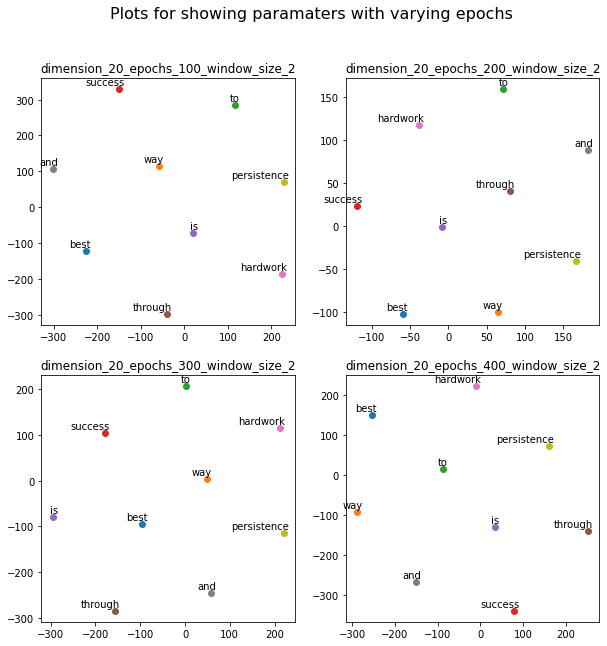

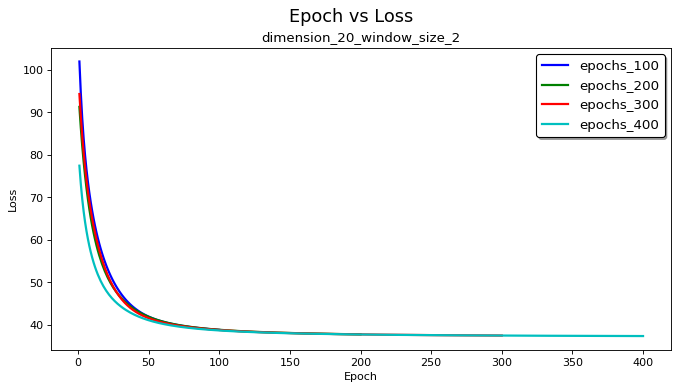

In [ ]:
epochs = [100,200,300,400]
loss_epoch = {}
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(10,10),)
fig.suptitle("Plots for showing paramaters with varying epochs", fontsize=16)
row=0
col=0
for epoch in epochs:
    
    epoch_loss,weights_1,weights_2 = train(dimension,window_size,epoch,training_data,learning_rate)
    loss_epoch.update( {epoch: epoch_loss} )
    
    word_similarity_scatter_plot(
        index_to_word,
        weights_1[epoch -1],
        'dimension_' + str(dimension) + '_epochs_' + str(epoch) + '_window_size_' +str(window_size),
        fig,
        axes[row][col]
    )
    if col == 1:
        row += 1
        col = 0
    else:
        col += 1
plt.savefig(path_to_save_scatter_plot+'varying_epochs' +'.png')                
plt.show()
plot_epoch_loss('epochs_',loss_epoch,'dimension_' + str(dimension) + '_window_size_' +str(window_size),path_to_save)

<h4> Bigger Corpus </h4>

In [ ]:
path_to_save = 'IMAGES/epoc_loss_plot/'
path_to_save_scatter_plot = 'IMAGES/word_similarity_scatter_plot/'

In [ ]:
def word_similarity_scatter_plot_bigger_corpus(index_to_word,weight,plot_title,path):
    
    labels = []
    tokens = []
    
    for key,value in index_to_word.items():
        tokens.append(weight[key])
        labels.append(value)
        
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)
    
    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
    
    x = x[0:200]
    y = y[0:200]
    
    plt.figure(figsize=(20, 30)) 

    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom',
                    family='fantasy')
    plt.title(plot_title)
    plt.savefig(path+plot_title +'.png')
    plt.close()   

<h4>1. Stop words effect<h4>

In [ ]:
epochs = 200
top_n_words = 5
dimension = 50
window_size = 2
learning_rate = 0.01



<h4>Without stopwords </h4>

In [ ]:
# text = get_file_data('yes')
word_to_index,index_to_word,corpus,vocab_size,length_of_corpus = generate_dictinoary_data(text_og)
training_data,training_sample_words = generate_training_data(corpus,window_size,vocab_size,word_to_index,length_of_corpus)
print('Number of unique words:' , vocab_size)
print('Length of corpus :',length_of_corpus)
words_subset = []
words_subset = np.random.choice(list(word_to_index.keys()),top_n_words)
print(words_subset)

Number of unique words: 5107
Length of corpus : 13604
['october' 'ennium' 'jebel' 'wakeless' 'prof']


In [ ]:
loss_epoch = {}
dataframe_sim = []

epoch_loss,weights_1,weights_2 = train(dimension,window_size,epochs,training_data,learning_rate,'yes',50)
loss_epoch.update( {'yes': epoch_loss} )

word_similarity_scatter_plot_bigger_corpus(
    index_to_word,
    weights_1[epochs -1],
    'Stopwords_removed_dimension_' + str(dimension) + '_epochs_' + str(epochs) + '_window_size_' +str(window_size),
    path_to_save_scatter_plot
)

df = print_similar_words(
    top_n_words,
    weights_1[epochs - 1],
    'sim_matrix for : Stopwords_removed_dimension_' + str(dimension) + '_epochs_' + str(epochs) + '_window_size_' +str(window_size),
    words_subset
)
dataframe_sim.append(df)

plot_epoch_loss(
    'Stopwords_removed_',
    loss_epoch,
    'Without_Stopwords_epochs_' + str(epochs) + '_window_size_' +str(window_size),
    path_to_save
)

Epoch: 0. Loss:570989.715610663


KeyboardInterrupt: ignored

Similarity matrix

In [ ]:
for i in range(len(dataframe_sim)):
    display(dataframe_sim[i])

<h4>With stopwords </h4>

In [ ]:
text = get_file_data()
word_to_index,index_to_word,corpus,vocab_size,length_of_corpus = generate_dictinoary_data(text)
training_data,training_sample_words = generate_training_data(corpus,window_size,vocab_size,word_to_index,length_of_corpus)
print('Number of unique words:' , vocab_size)
print('Length of corpus :',length_of_corpus)

NameError: ignored

In [ ]:
loss_epoch = {}
dataframe_sim = []

epoch_loss,weights_1,weights_2 = train(dimension,window_size,epochs,training_data,learning_rate,'yes',50)
loss_epoch.update( {'no': epoch_loss} )

word_similarity_scatter_plot_bigger_corpus(
    index_to_word,
    weights_1[epochs -1],
    'Stopwords_not_removed_dimension_' + str(dimension) + '_epochs_' + str(epochs) + '_window_size_' +str(window_size),
    path_to_save_scatter_plot
)

df = print_similar_words(
    top_n_words,
    weights_1[epochs - 1],
    'sim_matrix for : Stopwords_not_removed_dimension_' + str(dimension) + '_epochs_' + str(epochs) + '_window_size_' +str(window_size),
    words_subset
)
dataframe_sim.append(df)
plot_epoch_loss(
    'Stopwords_removed_',
    loss_epoch,
    'With_Stopwords_epochs_' + str(epochs) + '_window_size_' +str(window_size),
    path_to_save
)

Similarity matrix

In [ ]:
for i in range(len(dataframe_sim)):
    display(dataframe_sim[i])

<h4> For further variations we will be removing stopwords </h4>

In [ ]:
epochs = 200
top_n_words = 5
learning_rate = 0.01

In [ ]:
text = get_file_data('yes')
word_to_index,index_to_word,corpus,vocab_size,length_of_corpus = generate_dictinoary_data(text)
print('Number of unique words:' , vocab_size)
print('Length of corpus :',length_of_corpus)
words_subset = []
words_subset = np.random.choice(list(word_to_index.keys()),top_n_words)
print(words_subset)

<h4>2. Varying dimensions of word embedding </h4>

In [ ]:
window_size = 2
training_data,training_sample_words = generate_training_data(corpus,window_size,vocab_size,word_to_index,length_of_corpus)

In [ ]:
dimensions = [10,30,50,70,90]
loss_epoch = {}
dataframe_sim = []
for dim in dimensions:
    print('Running for dimension :' ,dim)
    
    epoch_loss,weights_1,weights_2 = train(dim,window_size,epochs,training_data,learning_rate,'yes',50)
    loss_epoch.update( {dim: epoch_loss} )
    
    word_similarity_scatter_plot_bigger_corpus(
        index_to_word,
        weights_1[epochs -1],
        'varying_dimension_' + str(dim) + '_epochs_' + str(epochs) + '_window_size_' +str(window_size),
        path_to_save_scatter_plot
    )
    
    df = print_similar_words(
        top_n_words,
        weights_1[epochs - 1],
        'sim_matrix for : dimension_' + str(dim) + '_epochs_' + str(epochs) + '_window_size_' +str(window_size),
        words_subset
    )
    dataframe_sim.append(df)
    
plot_epoch_loss(
    'dim:',
    loss_epoch,
    'epochs_' + str(epochs) + '_window_size_' +str(window_size),
    path_to_save
)

Similarity matrix

In [ ]:
for i in range(len(dataframe_sim)):
    display(dataframe_sim[i])

<h4>3. Varying window size </h4>

In [ ]:
dimension = 70
learning_rate = 0.01

In [ ]:
window_size = [2,5,7,9,12]
loss_epoch = {}
dataframe_sim = []
for ws in window_size:
    print('Running for window_size :' ,ws)
    
    training_data,training_sample_words = generate_training_data(corpus,ws,vocab_size,word_to_index,length_of_corpus)
    
    epoch_loss,weights_1,weights_2 = train(dimension,ws,epochs,training_data,learning_rate,'yes',50)
    loss_epoch.update( {ws: epoch_loss} )
    
    word_similarity_scatter_plot_bigger_corpus(
        index_to_word,
        weights_1[epochs -1],
        'varuing_window_size_' + str(ws) + '_epochs_' + str(epochs) + 'dimension_' +str(dimension),
        path_to_save_scatter_plot
    )
    
    df = print_similar_words(
        top_n_words,
        weights_1[epochs - 1],
        'sim_matrix for : dimension_' + str(dimension) + '_epochs_' + str(epochs) + '_window_size_' +str(ws),
        words_subset
    )
    dataframe_sim.append(df)
    
plot_epoch_loss(
    'window_size:',
    loss_epoch,
    'epochs_' + str(epochs) + '_dimension_' +str(dimension),
    path_to_save
)

Similarity matrix

In [ ]:
for i in range(len(dataframe_sim)):
    display(dataframe_sim[i])

<h4> Final training with dimension = 70 , window_size = 2 , epochs = 1000 </h4>

In [ ]:
print(words_subset)
window_size = 2
dimension = 70
epochs = 1000

In [ ]:
training_data,training_sample_words = generate_training_data(corpus,window_size,vocab_size,word_to_index,length_of_corpus)

In [ ]:
loss_epoch = {}
dataframe_sim = []
    
epoch_loss,weights_1,weights_2 = train(dim,window_size,epochs,training_data,learning_rate,'yes',200)
loss_epoch.update( {'': epoch_loss} )

word_similarity_scatter_plot_bigger_corpus(
    index_to_word,
    weights_1[epochs -1],
    'dimension_' + str(dimension) + '_epochs_' + str(epochs) + '_window_size_' +str(window_size),
    'final_training_scatter_plot_'
)

df = print_similar_words(
    top_n_words,
    weights_1[epochs - 1],
    'sim_matrix for : dimension_' + str(dimension) + '_epochs_' + str(epochs) + '_window_size_' +str(window_size),
    words_subset
)
dataframe_sim.append(df)

plot_epoch_loss(
    'Final_training',
    loss_epoch,
    ' epochs_' + str(epochs) + '_window_size_' +str(window_size) + '_dimension_' +str(dimension),
    'final_training_epoch_loss_plot_'
)

In [ ]:
for i in range(len(dataframe_sim)):
    display(dataframe_sim[i])